## Colab Setup

In [ ]:
"""
Change directory to where this file is located
"""
%cd '/content/drive/PATH/TO/MNIST_DATA_FILE'

## Import Modules

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
import scipy

## K-Nearest Neighbor Implementation

In [45]:
class KNN:
    """ k-nearest neighbor classifier class """

    def train(self, X, y):
        """
        Train the classifier using the given training data (X, y).
        Recall that for k-nearest neighbors this is just memorizing the training data.

        Do NOT Modify this method.

        Inputs
        - X: A numpy array of shape (N, D), where N is the number of data points,
            D is the dimensionality of each data point.
        - y: A numpy array of shape (N,) containing the training labels, where
            y[i] is the label for X[i]. With C classes, each y[i] is an integer
            from 0 to C-1.
        """
        self.X_train = X
        self.y_train = y

    def inference(self, X_test, k=1, dist_metric='dot'):
        """
        For each test example in X, this method predicts its label by majority vote
        from the k nearest training samples. It returns the predicted labels.

        Do NOT Modify this method.

        Inputs
        - X_test: A numpy array of shape (N, D), where N is the number of test data points,
            D is the dimensionality of each data point.
        - X_train: A numpy array of shape (M, D), where M is the number of training data points,
            D is the dimensionality of each data point.
        - k: The number of neighbors to participate in voting.
            dist_metric: Determines the distance metric to use. The default is dot-product ('dot'),
            but you will need to implement 'l2' for question (b).
        Returns
        - y_pred: A numpy array of shape (N,) containing predicted labels for the test data X,
            where y_pred[i] is the predicted label for the test point X[i].
        """
        dists = self.compute_distance(X_test, dist_metric)
        y_pred = self.predict_labels(X_test, dists, k)
        return y_pred
    
    
       

    def compute_distance(self, X_test, dist_metric='l2'):
        """
        Computes the distance between the training data and test data,
        using dot-product similarity or Euclidean (L2) distance as the distance metric.

        Question (a)

        Inputs
        - X_test: A numpy array of shape (N, D), where N is the number of test data points,
            D is the dimensionality of each data point.
        - X_train: A numpy array of shape (M, D), where M is the number of training data points,
            D is the dimensionality of each data point.
        - dist_metric: Determines the distance metric to use.
        Returns
        - dists: A numpy array of shape (N, M) where N is the number of test data points,
            and M is the number of traininig data points, containing distances between
            each pair of test and train data points based on the given distance metric.
        """
        N = X_test.shape[0]
        M = self.X_train.shape[0]
        dists = np.zeros((N, M))
        if dist_metric == 'dot':
            dists = -np.dot(X_test, self.X_train.T)
        elif dist_metric == 'l2':
            dists = np.sqrt(
                np.sum(X_test**2, axis=1, keepdims=True) +  # (N, 1)
                np.sum(self.X_train**2, axis=1) -           # (M,)
                2 * np.dot(X_test, self.X_train.T)          # (N, M)
            )
        elif dist_metric == 'cos':
            # Normalize X_test and X_train
            X_test_norm = X_test / np.linalg.norm(X_test, axis=1, keepdims=True)  # (N, D)
            X_train_norm = self.X_train / np.linalg.norm(self.X_train, axis=1, keepdims=True)  # (M, D)

            # Compute cosine similarity
            cosine_similarity = np.dot(X_test_norm, X_train_norm.T)  # (N, M)

            # Convert to cosine distance
            dists = 1 - cosine_similarity
        else:
            raise ValueError('Invalid value for dist_metric')
        return dists
        

    def predict_labels(self, X_test, dists, k):
        """
        For the given test image, this method takes a majority vote from k closest points
        to predict the class of the test image.

        Question (b)

        Inputs
        - X_test: A numpy array of shape (N, D), where N is the number of test data points,
            D is the dimensionality of each data point.
        - dists: A numpy array of shape (N, M) where N is the number of test data points,
            and M is the number of traininig data points, containing distances between
            each pair of test and train data points based on the given distance metric.
        - k: The number of neighbors to participate in voting.
        Returns
        - y_pred: A numpy array of shape (N,) containing predicted labels for the test data X,
            where y_pred[i] is the predicted label for the test point X[i].
        """
        N = X_test.shape[0]
        y_pred = np.zeros(N, dtype=int)

        for i in range(N):
            # 각 테스트 포인트에 대해 거리 기반으로 k개의 최근접 이웃 인덱스 찾기
            nearest_neighbors = np.argsort(dists[i])[:k]

            # 최근접 이웃의 레이블 가져오기
            closest_y = self.y_train[nearest_neighbors]

            # 각 클래스의 빈도 계산
            unique_labels, counts = np.unique(closest_y, return_counts=True)

            # 가장 빈도가 높은 레이블 선택
            y_pred[i] = unique_labels[np.argmax(counts)]

        return y_pred

    def evaluate(self, y, y_hat):
        """
        Compares the predicted labels to the ground truth y, and prints the
        classification accuracy.

        Do NOT Modify this method.

        Inputs
        - y: A numpy array of shape (N,) containing the ground truth labels, where
            N is the number of test examples. With C classes, each y[i] is an integer
            from 0 to C-1.
        - y_hat: A numpy array of shape (N,) containing the predicted labels, where
            N is the number of test examples. With C classes, each y_pred[i] is
            an integer from 0 to C-1.
        Returns:
        - accuracy
        """
        y_hat = np.expand_dims(y_hat, axis=1)
        num_correct = np.sum(y_hat == y)
        accuracy = float(num_correct) / y.shape[0]
        return accuracy

## Data Loading (MNIST)

In [24]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms

class MNIST:
    """ Dataset and DataLoader for the MNIST dataset """

    def __init__(self, train_batch_size, test_batch_size):
        """
        Do NOT modify this function.
        """
        self.test_batch_size = test_batch_size
        self.train_batch_size = train_batch_size

    def set_data(self):
        """
        Download and Set the Training and Test data using the MNIST dataset
        Use "torchvision.datasets" module.

        Question (c)

        Conditions :
        - Data should be "downloaded" in the "data" directory of the current path
        - Data should be in "Tensor" form of pytorch.

        Returns :
        - train_data
        - test_data
        """
        data_dir = "data"
        print("Downloading the MNIST data...")
        train_data = datasets.MNIST(root=data_dir, train=True, download=True, transform=ToTensor())
        test_data = datasets.MNIST(root=data_dir, train=False, download=True, transform=ToTensor())

        return train_data, test_data

    def load_data(self, train_data, test_data):
        """
        Create DataLoaders that iterate the train_data and the test_data.
        Each iteration of the dataloaders should return a batch of the data.
        Make sure that the data is shuffled after iterating over all batches.
        Use DataLoader class in pytorch.

        Question (c)

        Input :
        - train_data
        - test_data

        Returns :
        - train_loader
        - test_loader
        """
        
        train_loader = DataLoader(train_data, batch_size=self.train_batch_size, shuffle = True)
        test_loader = DataLoader(test_data, batch_size=self.test_batch_size, shuffle = True)

        return train_loader, test_loader

    def print_example(self, test_loader):
        """
        Check out a sample of the test data.

        Question (c)
        (1) Extract one batch from the test_loader and print out a shape of the images in the batch.
        (2) Print out 6 images in a rectangular form (height*width = 2*3).

        Conditions :
        - Print out the Ground truths (labels) above each image as title.
            ex. Ground Truch : 8
        - Remove ticks and tick labels in the plot.
        - Print out the images in grayscale.
        - Refer to the format of the expected result below for your answer.

        Input :
        - test_loader
        """

        images, label = next(iter(test_loader))
        print("A shape of the images in a batch:", images.shape)

        fig = plt.figure()
        for i in range(6):
          plt.subplot(2, 3, i + 1)
          plt.imshow(images[i][0,:,:],cmap = "gray")
          plt.axis('off')
          plt.tight_layout()
          plt.title(f"Ground Truth : {label[i]}")
        print(fig)

A shape of the images in a batch: torch.Size([400, 1, 28, 28])
Figure(640x480)


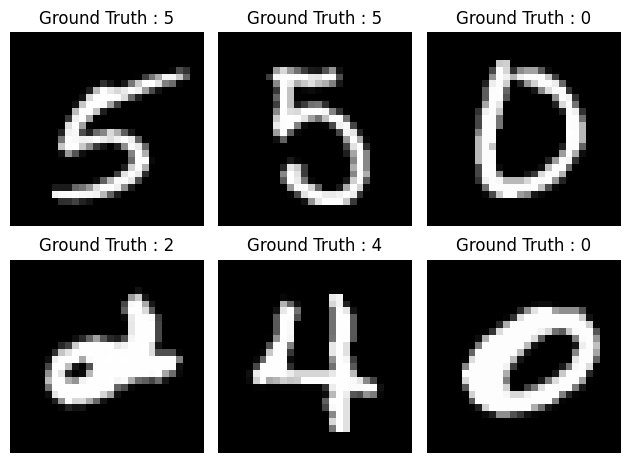

In [19]:
num_train_data = 2000
num_test_data = 400

mnist = MNIST(train_batch_size=num_train_data, test_batch_size=num_test_data)
train_data, test_data = mnist.set_data()
train_loader, test_loader = mnist.load_data(train_data, test_data)
mnist.print_example(test_loader)

**Expected Result**

A shape of the images in a batch: torch.Size([200, 1, 28, 28])

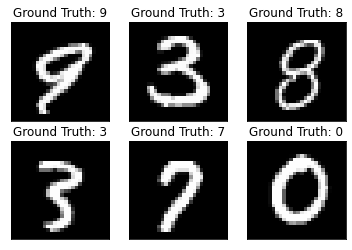

In [20]:
X_train, y_train = next(iter(train_loader))
X_train = X_train.reshape(num_train_data, -1).numpy()
y_train = y_train.unsqueeze(1).numpy()

X_test, y_test = next(iter(test_loader))
X_test = X_test.reshape(num_test_data, -1).numpy()
y_test = y_test.unsqueeze(1).numpy()

print('Sampling Training & Test Data.....\n')
print('Training data shape: {}'.format(X_train.shape))
print('Training labels shape: {}'.format(y_train.shape))
print('Test data shape: {}'.format(X_test.shape))
print('Test labels shape: {}'.format(y_test.shape))

Sampling Training & Test Data.....

Training data shape: (2000, 784)
Training labels shape: (2000, 1)
Test data shape: (400, 784)
Test labels shape: (400, 1)


## Model Training & Evaluation

In [46]:
model = KNN()
model.train(X_train, y_train)

In [47]:
"""
Model usage for test.
"""
K = 15
y_pred = model.inference(X_test, k=K, dist_metric='l2')
acc = model.evaluate(y_test, y_pred)
print("Accuarcy:", acc)

Accuarcy: 0.8975


## Experiments

In [48]:
# Modify the number of k's and metrics to try as you want
num_ks = 50
metrics = ['dot', 'cos', 'l2']

In [49]:
# Run experiments
print_k_interval = 5
result = dict(zip(metrics, [[] for _ in range(len(metrics))]))
for metric in metrics:
    print("running KNN with {} distance metric".format(metric))
    for k in range(1, num_ks+1):
        if k % print_k_interval==0:
            print("    processing... k={:3d}".format(k))
        y_pred = model.inference(X_test, k=k, dist_metric=metric)
        acc = model.evaluate(y_test, y_pred)
        result[metric].append(acc)
    print()

running KNN with dot distance metric
    processing... k=  5
    processing... k= 10
    processing... k= 15
    processing... k= 20
    processing... k= 25
    processing... k= 30
    processing... k= 35
    processing... k= 40
    processing... k= 45
    processing... k= 50

running KNN with cos distance metric
    processing... k=  5
    processing... k= 10
    processing... k= 15
    processing... k= 20
    processing... k= 25
    processing... k= 30
    processing... k= 35
    processing... k= 40
    processing... k= 45
    processing... k= 50

running KNN with l2 distance metric
    processing... k=  5
    processing... k= 10
    processing... k= 15
    processing... k= 20
    processing... k= 25
    processing... k= 30
    processing... k= 35
    processing... k= 40
    processing... k= 45
    processing... k= 50



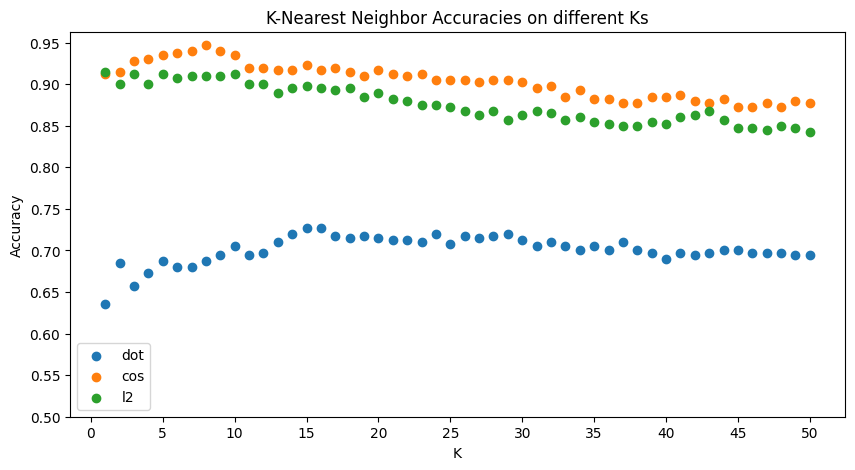

In [50]:
# Visualize the result
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)

x_axis = np.arange(1, num_ks+1, 1)
for i, metric in enumerate(metrics):
    ax.scatter(x_axis, result[metric], label = metric)

ax.set(title="K-Nearest Neighbor Accuracies on different Ks")
ax.set(xlabel='K', ylabel='Accuracy')
ax.set(xticks=np.arange(0, num_ks+1,5), yticks=np.arange(0.5,1.0,0.05))
ax.legend()
plt.show()

In [44]:
###
# Question (d)
# Briefly report what you observe in the plot above.
###


The plot shows the accuracies of a k-Nearest Neighbor (KNN) classifier with different values of k (the number of neighbors considered). The plot has three lines, each representing a different metric used for calculating nearest neighbors:

As k increases from 0 to 50:

- The accuracy for the metric represented by "dot" initially increases with k, peaks at around k=13, and then generally decreases.
- The accuracy for "cos" and "l2" remains relatively stable and high, with slight fluctuations.

Across the range, "cos" and "l2" have higher accuracies than "dot", suggesting that for this particular data, cosine similarity and L2 distance are more effective metrics for KNN classification than dot product similarity. The highest accuracy for "l2" and "cos" appears to occur at lower values of k (k = 4), while "dot" tends to reach high accuracy at a higher value of k (k = 13) and maintains it.
